In [229]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [226]:
# Load data
years = [2019, 2020, 2021, 2022, 2023, 2024]
cols = ['game_id', 'Date', 'season', 'Home', 'Away', 'jumpball_home', 'jumpball_away', 'jumpball_possession_tm']
jumpballs = pd.concat([pd.read_csv(f'data/first_basket_{year}.csv')[cols] for year in years])
jumpballs = jumpballs.dropna()

In [227]:
# Create player historical records
history = jumpballs.melt([c for c in jumpballs.columns if c not in ['jumpball_home', 'jumpball_away']], var_name = 'win', value_name = 'player_id').sort_values('game_id')

history['home'] = (history['win'] == 'jumpball_home').astype(int)

history['win'] = (
    (history['win'] == 'jumpball_home') * (history['jumpball_possession_tm'] == history['Home'])
    + (history['win'] == 'jumpball_away') * (history['jumpball_possession_tm'] == history['Away'])
).astype(int)

history = history[['game_id', 'season', 'Date', 'home', 'player_id', 'win']].sort_values(['player_id', 'Date']).reset_index(drop = True)

history.sample(10)

,game_id,season,Date,home,player_id,win
12246,201811280OKC,2019,2018-11-28,0,thomptr01,1
7583,202302150DEN,2023,2023-02-15,1,jokicni01,1
12476,201912010MIN,2020,2019-12-01,1,townska01,1
8067,202312080UTA,2024,2023-12-08,1,kesslwa01,0
5957,202402040MIN,2024,2024-02-04,1,goberru01,1
11799,202304040HOU,2023,2023-04-04,1,sengual01,0
2104,202102050OKC,2021,2021-02-05,1,bazleda01,1
4634,202002240PHI,2020,2020-02-24,1,embiijo01,1
8743,202012290MIA,2021,2020-12-29,0,lopezbr01,1
1410,201902100SAC,2019,2019-02-10,0,aytonde01,1


In [228]:
# Compute career jumpball win rate
history['win_rate'] = history.groupby('player_id')['win'].expanding().mean().reset_index(level = 0, drop = True)
history['win_rate'] = history.groupby('player_id')['win_rate'].shift()
# Compute career jumpball win rate
history['win_rate_25'] = history.groupby('player_id')['win'].rolling(25, min_periods = 1).mean().reset_index(level = 0, drop = True)
history['win_rate_25'] = history.groupby('player_id')['win_rate_25'].shift()
# Compute career jumpball volume
history['volume'] = history.groupby('player_id')['win'].expanding().count().reset_index(level = 0, drop = True)
history['volume'] = history.groupby('player_id')['volume'].shift()

In [187]:
history.sample(5)

,game_id,season,Date,home,player_id,win,win_rate,win_rate_25,volume
8017,202104200POR,2021,2021-04-20,1,kanteen01,0,0.313433,0.24,67.0
10551,202111280IND,2022,2021-11-28,0,portibo01,1,0.451613,0.48,31.0
6294,201812020CHO,2019,2018-12-02,1,hernawi01,0,NaN,NaN,NaN
12173,202008210PHI,2020,2020-08-21,0,theisda01,1,0.313433,0.32,67.0
9523,202201240CLE,2022,2022-01-24,0,noelne01,1,0.516129,0.48,62.0


In [200]:
data = pd.merge(history.groupby('home').get_group(1).drop(columns = 'home'),
                history.groupby('home').get_group(0).drop(columns = 'home'),
                on = ['game_id', 'season', 'Date'],
                suffixes = ['_home', '_away']).drop(columns = 'win_away')

data.dropna(inplace = True)

In [220]:
features = ['win_rate_home', 'win_rate_25_home', 'win_rate_away', 'win_rate_25_away']
#features = ['win_rate_home', 'win_rate_away']

In [221]:
train = data.copy()[(data['season'] > 2019) & (data['season'] < 2024)]
test = data.copy()[data['season'] == 2024]

In [222]:
X_train = train[features].to_numpy()
X_test = test[features].to_numpy()

y_train = train['win_home'].to_numpy()
y_test = test['win_home'].to_numpy()

In [223]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [224]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, -1]

In [225]:
(y_pred == y_test).mean(), roc_auc_score(y_test, y_pred_prob)

(0.622187742435997, 0.6817614878596127)

In [253]:
ks = np.arange(1, 151)
accs, aucs = [], []
accs_t, aucs_t = [], []
for k in ks :

    # Create player historical records
    history = jumpballs.melt([c for c in jumpballs.columns if c not in ['jumpball_home', 'jumpball_away']], var_name = 'win', value_name = 'player_id').sort_values('game_id')

    history['home'] = (history['win'] == 'jumpball_home').astype(int)

    history['win'] = (
        (history['win'] == 'jumpball_home') * (history['jumpball_possession_tm'] == history['Home'])
        + (history['win'] == 'jumpball_away') * (history['jumpball_possession_tm'] == history['Away'])
    ).astype(int)

    history = history[['game_id', 'season', 'Date', 'home', 'player_id', 'win']].sort_values(['player_id', 'Date']).reset_index(drop = True)

    # Compute career jumpball win rate
    history['win_rate'] = history.groupby('player_id')['win'].expanding().mean().reset_index(level = 0, drop = True)
    history['win_rate'] = history.groupby('player_id')['win_rate'].shift()
    # Compute career jumpball win rate
    history[f'win_rate_{k}'] = history.groupby('player_id')['win'].rolling(k, min_periods = 1).mean().reset_index(level = 0, drop = True)
    history[f'win_rate_{k}'] = history.groupby('player_id')[f'win_rate_{k}'].shift()

    data = pd.merge(history.groupby('home').get_group(1).drop(columns = 'home'),
                    history.groupby('home').get_group(0).drop(columns = 'home'),
                    on = ['game_id', 'season', 'Date'],
                    suffixes = ['_home', '_away']).drop(columns = 'win_away')

    data.dropna(inplace = True)

    train = data.copy()[(data['season'] > 2019) & (data['season'] < 2023)]
    test = data.copy()[data['season'] == 2023]

    features = [f'win_rate_{k}_home', f'win_rate_{k}_away', 'win_rate_home', 'win_rate_away']

    X_train = train[features].to_numpy()
    X_test = test[features].to_numpy()

    y_train = train['win_home'].to_numpy()
    y_test = test['win_home'].to_numpy()

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, -1]

    y_pred_t = model.predict(X_train)
    y_pred_prob_t = model.predict_proba(X_train)[:, -1]

    accs.append((y_pred == y_test).mean())
    aucs.append(roc_auc_score(y_test, y_pred_prob))

    accs_t.append((y_pred_t == y_train).mean())
    aucs_t.append(roc_auc_score(y_train, y_pred_prob_t))

In [254]:
import matplotlib.pyplot as plt

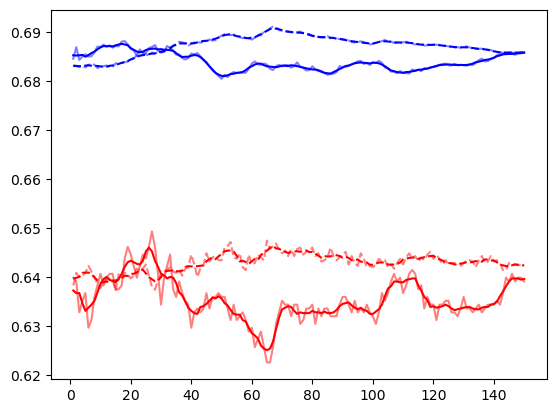

In [255]:
plt.plot(ks, pd.Series(accs).rolling(5, center = True, min_periods = 1).mean(), 'r-')
plt.plot(ks, accs, 'r-', alpha = 0.5)
plt.plot(ks, pd.Series(aucs).rolling(5, center = True, min_periods = 1).mean(), 'b-')
plt.plot(ks, aucs, 'b-', alpha = 0.5)

plt.plot(ks, pd.Series(accs_t).rolling(5, center = True, min_periods = 1).mean(), 'r--')
plt.plot(ks, accs_t, 'r--', alpha = 0.5)
plt.plot(ks, pd.Series(aucs_t).rolling(5, center = True, min_periods = 1).mean(), 'b--')
plt.plot(ks, aucs_t, 'b--', alpha = 0.5)

In [ ]:
data = (
    data
    .rename(columns = {
        'jumpball_home': 'player_home',
        'jumpball_away': 'player_away',
        'jumpball_possession_tm': 'win_team'
    })
)

data['y'] = (data['win_team'] == data['Home']).astype(int)

data.head()

In [30]:
data = data.melt([c for c in data.columns if c not in ['player_home', 'player_away']], var_name = 'home', value_name = 'name')

In [31]:
data['home'] = data['home'].str.replace('player_', '')

In [33]:
data.sort_values('game_id')

,game_id,Date,season,Home,Away,win_team,y,home,name
0,201810160BOS,2018-10-16,2019,BOS,PHI,PHI,0,home,horfoal01
7583,201810160BOS,2018-10-16,2019,BOS,PHI,PHI,0,away,embiijo01
1,201810160GSW,2018-10-16,2019,GSW,OKC,GSW,1,home,jonesda03
7584,201810160GSW,2018-10-16,2019,GSW,OKC,GSW,1,away,adamsst01
2,201810170CHO,2018-10-17,2019,CHO,MIL,MIL,0,home,zelleco01
...,...,...,...,...,...,...,...,...,...
7580,202406120DAL,2024-06-12,2024,DAL,BOS,DAL,1,home,gaffoda01
15164,202406140DAL,2024-06-14,2024,DAL,BOS,BOS,0,away,horfoal01
7581,202406140DAL,2024-06-14,2024,DAL,BOS,BOS,0,home,gaffoda01
7582,202406170BOS,2024-06-17,2024,BOS,DAL,BOS,1,home,horfoal01


In [ ]:
# Create function to create schedule features; season average and rolling mean
def create_features(df) :

    df[f'rate'] = df[f].rolling(9999, min_periods = 1).mean().shift(1)

    # Average and rolling mean: Four factors
    for f in ['eFG%', 'TOV%', 'FT/FGA', 'ORtg'] :
        df[f'{f}_avg'] = df[f].rolling(9999, min_periods = 1).mean().shift(1)
        for lag in lags_ff :
            df[f'{f}_{lag}'] = df[f].rolling(lag, min_periods = 1).mean().shift(1)

    # Lag streak
    df['Streak'] = df['Streak'].shift(1)

    # Rest and back-to-backs
    datetimes = pd.to_datetime(df['Date'].astype(str) + ' ' +  df['Time'])
    df['Rest'] = (datetimes - datetimes.shift(1)).apply(lambda x: x.total_seconds() / 3600 / 24 / 7) # Rest in weeks
    df['B2B'] =  ((df['Date'] - df['Date'].shift(1)) < timedelta(days = 2)).astype(int) # Binary back-to-back
    df['G_2weeks'] = df['Date'].apply(lambda x: len(df.copy()[(df['Date'] >= x - timedelta(days = 14)) & (df['Date'] <= x)])) # Num. games past two weeks

    return df

lags_schedule = [3, 6, 9, 12]
lags_ff = [5, 10]
schedules = schedules.groupby(['Year', 'Team'], group_keys = False).apply(create_schedule_features, lags_schedule, lags_ff)